# Reconstruyendo una serie de tiempo diferenciada por fracciones

Una serie de tiempo diferenciada por fracciones se puede expresar como:


$$\widehat{X_t}  = \sum_{k=0}^\infty \omega_k X_{t-k}$$ 

Donde:

   $\widehat{X_t}$:  Es el valor diferenciado por fracciones en t
   
   $X$: corresponde a un vector de lecturas de precios ${X_t, X_{t-1}, … , X_{t-k-1}, ...  }$
   
   $\omega$:  Es un vector de pesos hallados iterativamente como:
      
   $\omega_k = -\omega_{k-1} \frac{d-k+1}{k}$

Como la serie de tiempos en la práctica no son infinitas, el autor propone un método para establecer una ventana de longitud fija.  La forma de hallar este limite $l^*$ es mediante un proceso iterativo en donde los pesos dejan de ser mayores a un umbral $\tau  \epsilon [0,1]$.  Entonces $\omega_k$ deberá cumplir las siguientes condiciones:

$$
\omega_k = \begin{cases}
1 & \text{sí } k = 0 \\
\omega_k & \text{sí } k \leq l^*\\
0 & \text{sí } k > l^*
\end{cases}
$$

Entonces, la serie de tiempo diferenciada se puede reescribir de ésta manera:

$$\widehat{X_t}  = \sum_{k=0}^{l^*} \omega_k X_{t-k}$$

$$\widehat{X_t}  = \omega_0 X_{t} + \sum_{k=1}^{l^*} \omega_k X_{t-k}$$

$$\omega_0 X_{t} = \widehat{X_t} - \sum_{k=1}^{l^*} \omega_k X_{t-k}$$

$$X_{t} = \widehat{X_t} - \sum_{k=1}^{l^*} \omega_k X_{t-k}$$    

# Cargando las librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from tqdm import tqdm
import datetime as dt
#from pandas.tseries.holiday import USFederalHolidayCalendar
#from pandas.tseries.offsets import CustomBusinessDay
import warnings


In [2]:
warnings.filterwarnings('ignore') 

# Cargando los datos

Fuente: https://www.nasdaq.com/market-activity/stocks/nvda/historical?page=1&rows_per_page=10&timeline=y10

In [3]:
df = pd.read_csv("../data/NVDA_HistoricalData_1743020375430.csv", parse_dates=True, index_col='date')

In [4]:
df.head()

,close,volume,open,high,low
date,,,,,
2025-03-25,120.69,167447200,120.545,121.290,118.92
2025-03-24,121.41,228452500,119.880,122.220,119.34
2025-03-21,117.70,266498500,116.940,117.990,115.42
2025-03-20,118.53,248829700,116.550,120.200,116.47
2025-03-19,117.52,273426200,117.270,120.445,115.68


In [5]:
df.sort_index(inplace=True)
df.head()

,close,volume,open,high,low
date,,,,,
2015-03-26,0.5241,311911880,0.5152,0.5264,0.5115
2015-03-27,0.5345,317702400,0.5273,0.5365,0.5188
2015-03-30,0.5367,252344680,0.5370,0.5395,0.5300
2015-03-31,0.5231,356999960,0.5353,0.5358,0.5228
2015-04-01,0.5253,329899360,0.5253,0.5270,0.5162


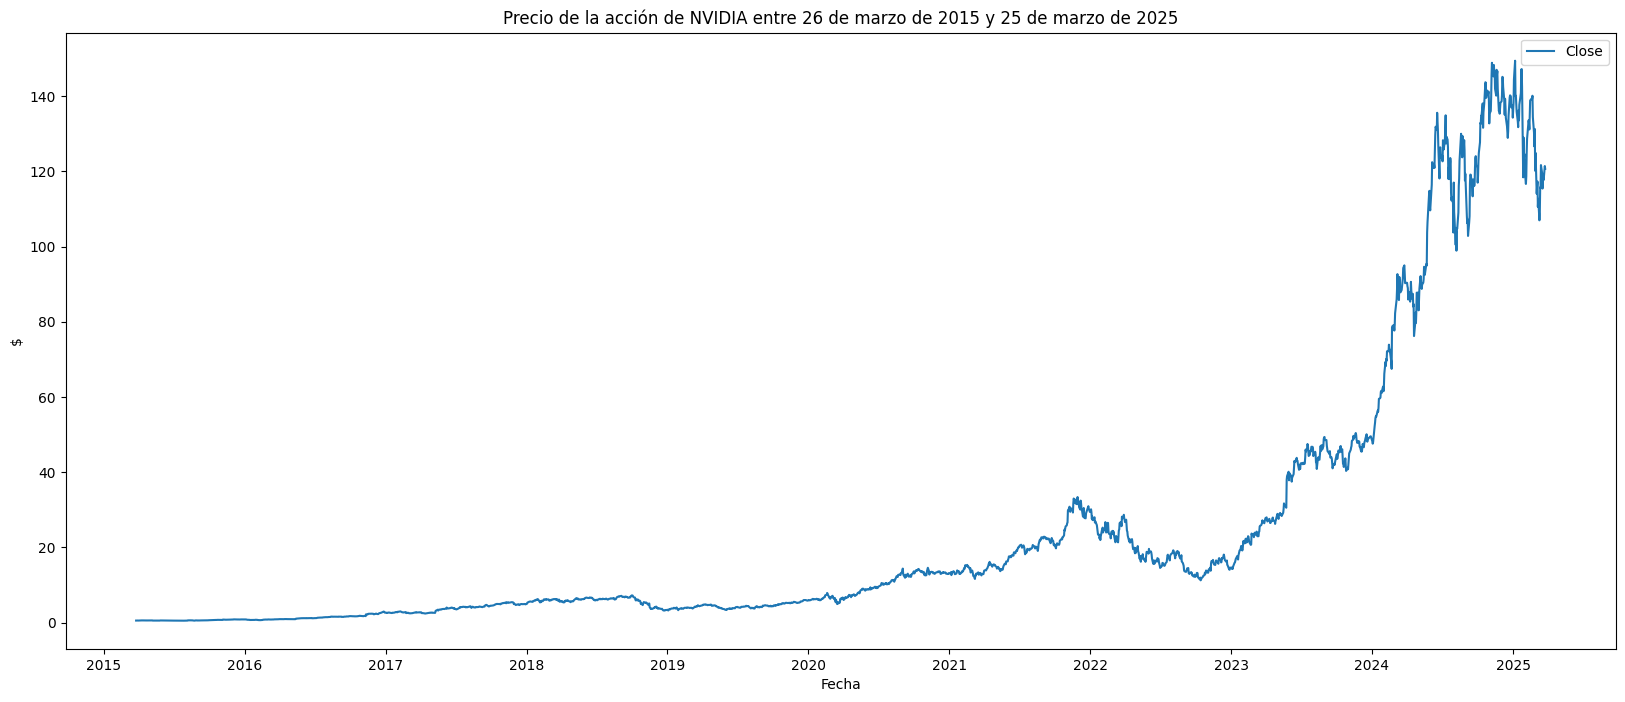

In [6]:
plt.figure(figsize=(20,8))
plt.title('Precio de la acción de NVIDIA entre 26 de marzo de 2015 y 25 de marzo de 2025')
plt.xlabel('Fecha')
plt.ylabel('$')
plt.plot(df.close, label='Close')
plt.legend()
plt.savefig('serie.png');

# Codigo

* Augmented_Dickey_Fuller_Test_func: https://github.com/Apress/hands-on-time-series-analylsis-python/blob/master/Chapter%204/4.%20SARIMA.ipynb

* fracDiff_FFD: Lopez de Prado, Advances in Financial Machine Learning, chapter 5.

* plotMinFFD: Lopez de Prado, Advances in Financial Machine Learning, chapter 5. 

In [7]:
def Augmented_Dickey_Fuller_Test_func(series, column_name):
    print(f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, maxlag=1,regression='c',autolag=None)
    # Maxlag =1 like  Lopez de Prado implementation
    # Create initial DataFrame
    dfoutput = pd.DataFrame({
        "Metric": ['Test Statistic', 'p-value', 'No Lags Used', 'Number of Observations Used'],
        "Value": dftest[0:4]
    })
    
    # Add Critical Values
    critical_values = pd.DataFrame({
        "Metric": [f"Critical Value ({key})" for key in dftest[4].keys()],
        "Value": list(dftest[4].values())
    })
    
    # Concatenate the initial DataFrame with Critical Values
    dfoutput = pd.concat([dfoutput, critical_values])
    
    print(dfoutput)

    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

def getWeights_FFD(d: float, thres: float = 1e-5) -> np.array:
    '''
    Compute FFD weights until weights drop below threshold
    Args:
        d: differencing factor (0 < d < 1)
        thres: weight cutoff threshold
    Returns:
        weights array (reversed order for convolution)
    '''
    w = [1.0]  # Initialize with ω₀ = 1
    k = 1
    while True:
        w_k = -w[-1] / k * (d - k + 1)  # Recursive weight calculation
        if abs(w_k) < thres: 
            break
        w.append(w_k)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)  # Reverse for convolution alignment
    return w


def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights_FFD(d,thres)
    width=len(w)-1
    #2) Apply weights to values
    df={}    
    for name in series.columns:
        seriesF,df_=series[[name]].ffill() .dropna(),pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1,name]):continue # exclude NAs
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    diff = [(i.Index, i.close) for i in df.itertuples()]
    df = pd.DataFrame(diff,columns=['idx', 'close']).set_index('idx')
    return df

def plotMinFFD(series, name, threshold=1e-5 ):
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    df0= series
    for d in np.linspace(0,1,101):
        df1=np.log(df0[[name]]).resample('1D').last() # downcast to daily obs
        df2=fracDiff_FFD(df1,d,thres=threshold)
        corr=np.corrcoef(df1.loc[df2.index,name],df2['close'])[0,1]
        df2=adfuller(df2[name],maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    plt.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    plt.savefig('min_d.png')
    return out

def reconstructed_values(Differenced, w_l, original, start):
    '''
    Differentiated: Forecasted time series differentiated by fractions to be reconstructed.
    w_l: Constant weight vector (fixed window = n)
    original: Data vector of the original time series of 
              dimension equal to w_l - 1
    start: Index where data inversion begins in df.  
           It is the last index of the df of the 
           undifferenced time series.
    '''
    original = np.array(original).flatten()
    Differenced = np.array(Differenced).flatten()
    n = len(Differenced)
    y_hat_reconstructed = []
    
    for f in range(n):
        y_hat = (Differenced[f] - np.dot(w_l[:-1].T, original))[0]
        y_hat_reconstructed.append(y_hat)
        original = np.append(original[1:], y_hat)

    return y_hat_reconstructed 
    

# Estacionariedad de la serie de tiempo sin diferenciar

Se selecciona la serie del precio de cierre para este ejercicio y se le aplica la prueba ADF

In [8]:
Augmented_Dickey_Fuller_Test_func(df.close, 'close')

Results of Dickey-Fuller Test for column: close
                        Metric        Value
0               Test Statistic     0.967872
1                      p-value     0.993915
2                 No Lags Used     1.000000
3  Number of Observations Used  2513.000000
0          Critical Value (1%)    -3.432955
1          Critical Value (5%)    -2.862691
2         Critical Value (10%)    -2.567383
Conclusion:====>
Fail to reject the null hypothesis
Data is non-stationary


# Ejemplos de vectores de ventana fija para diferentes umbrales

In [9]:
# Dimensiones de vectores para d variable y umbral constante
t = 1e-5
for d in np.arange (0, 1.1, 0.1):
    vec = getWeights_FFD(d, t)
    n = vec.shape[0] 
    print(f"Fractional Order d: {d:.2f}, threshold: {t}, Vector dimension: {n:,}")

Fractional Order d: 0.00, threshold: 1e-05, Vector dimension: 1
Fractional Order d: 0.10, threshold: 1e-05, Vector dimension: 4,076
Fractional Order d: 0.20, threshold: 1e-05, Vector dimension: 3,382
Fractional Order d: 0.30, threshold: 1e-05, Vector dimension: 2,275
Fractional Order d: 0.40, threshold: 1e-05, Vector dimension: 1,458
Fractional Order d: 0.50, threshold: 1e-05, Vector dimension: 927
Fractional Order d: 0.60, threshold: 1e-05, Vector dimension: 590
Fractional Order d: 0.70, threshold: 1e-05, Vector dimension: 372
Fractional Order d: 0.80, threshold: 1e-05, Vector dimension: 228
Fractional Order d: 0.90, threshold: 1e-05, Vector dimension: 125
Fractional Order d: 1.00, threshold: 1e-05, Vector dimension: 2


In [10]:
# Dimensiones de vectores para d constante y umbral variable
d = 0.1
for i in range(1, 6):
    t = 10 ** -i
    vec = getWeights_FFD(d, t)
    n = vec.shape[0] 
    print(f"Fractional Order d: {d:.2f}, threshold: {t: .5f}, Vector dimension: {n:,}")

Fractional Order d: 0.10, threshold:  0.10000, Vector dimension: 1
Fractional Order d: 0.10, threshold:  0.01000, Vector dimension: 8
Fractional Order d: 0.10, threshold:  0.00100, Vector dimension: 62
Fractional Order d: 0.10, threshold:  0.00010, Vector dimension: 503
Fractional Order d: 0.10, threshold:  0.00001, Vector dimension: 4,076


In [11]:
# Dimensiones de vectores para d variable y umbral variable
for d in np.arange (0.1, 1., 0.1):
    for i in range(1, 6):
        t = 10 ** -i
        vec = getWeights_FFD(d, t)
        n = vec.shape[0] 
        print(f"Fractional Order d: {d:.1f}, threshold: {t: .5f}, Vector dimension: {n:,}")

Fractional Order d: 0.1, threshold:  0.10000, Vector dimension: 1
Fractional Order d: 0.1, threshold:  0.01000, Vector dimension: 8
Fractional Order d: 0.1, threshold:  0.00100, Vector dimension: 62
Fractional Order d: 0.1, threshold:  0.00010, Vector dimension: 503
Fractional Order d: 0.1, threshold:  0.00001, Vector dimension: 4,076
Fractional Order d: 0.2, threshold:  0.10000, Vector dimension: 2
Fractional Order d: 0.2, threshold:  0.01000, Vector dimension: 11
Fractional Order d: 0.2, threshold:  0.00100, Vector dimension: 73
Fractional Order d: 0.2, threshold:  0.00010, Vector dimension: 497
Fractional Order d: 0.2, threshold:  0.00001, Vector dimension: 3,382
Fractional Order d: 0.3, threshold:  0.10000, Vector dimension: 3
Fractional Order d: 0.3, threshold:  0.01000, Vector dimension: 12
Fractional Order d: 0.3, threshold:  0.00100, Vector dimension: 66
Fractional Order d: 0.3, threshold:  0.00010, Vector dimension: 388
Fractional Order d: 0.3, threshold:  0.00001, Vector dime

# Seleccionando el d mínimo para la serie de precios de Nvidia

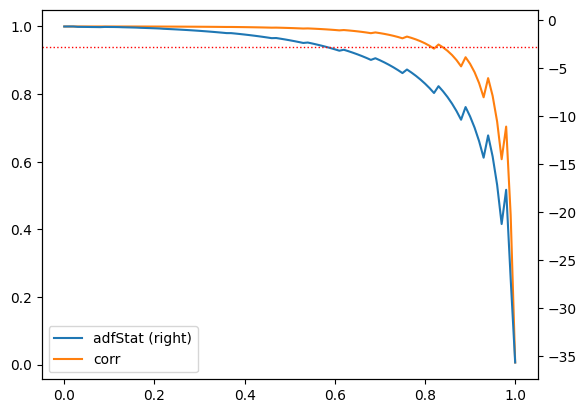

In [12]:
series = df[['close']].copy()
t = 0.01
out = plotMinFFD(series, 'close', t )

In [13]:
out[out['adfStat']< -2.862052]

,adfStat,pVal,lags,nObs,95% conf,corr
0.59,-2.930919,4.186890e-02,1.0,2507.0,-2.862694,0.990603
0.60,-3.067144,2.908214e-02,1.0,2507.0,-2.862694,0.989608
0.61,-3.212190,1.928982e-02,1.0,2507.0,-2.862694,0.988498
0.62,-3.113054,2.560210e-02,1.0,2508.0,-2.862693,0.989446
0.63,-3.260849,1.672185e-02,1.0,2508.0,-2.862693,0.988310
0.64,-3.418637,1.033970e-02,1.0,2508.0,-2.862693,0.987038
0.65,-3.587289,6.008746e-03,1.0,2508.0,-2.862693,0.985612
0.66,-3.767769,3.254836e-03,1.0,2508.0,-2.862693,0.984010
0.67,-3.961158,1.628131e-03,1.0,2508.0,-2.862693,0.982207
0.68,-4.168656,7.441879e-04,1.0,2508.0,-2.862693,0.980175


In [14]:
d = out[out['adfStat']< -2.862052].iloc[0].name
corr =  out[out['adfStat']< -2.862052].iloc[0]['corr']
print(f"d: {d}, Autocorrelation (lag = 1): {corr}")

d: 0.59, Autocorrelation (lag = 1): 0.99060322922807


In [15]:
w_l = getWeights_FFD(d, t)
w_l

array([[-0.01063163],
       [-0.0132688 ],
       [-0.01716851],
       [-0.02335851],
       [-0.03425002],
       [-0.0568465 ],
       [-0.12095   ],
       [-0.59      ],
       [ 1.        ]])

In [16]:
w_l.shape

(9, 1)

#  Diferenciando para d<sub>mínimo</sub>  = 0.59 y t = 0.01

In [17]:
type(out[out['adfStat']< -2.862052].iloc[0].name)

numpy.float64

In [18]:
# series = df[['close']] #.loc[df.index.year>2020].copy()
d = out[out['adfStat']< -2.862052].iloc[0].name
fd_ts = fracDiff_FFD(series,d,t)
fd_ts.tail()

,close
idx,
2025-03-19,16.895681
2025-03-20,17.002534
2025-03-21,15.379167
2025-03-24,19.351669
2025-03-25,16.467564


In [19]:
fd_ts.shape, d, t

((2507, 1), 0.59, 0.01)

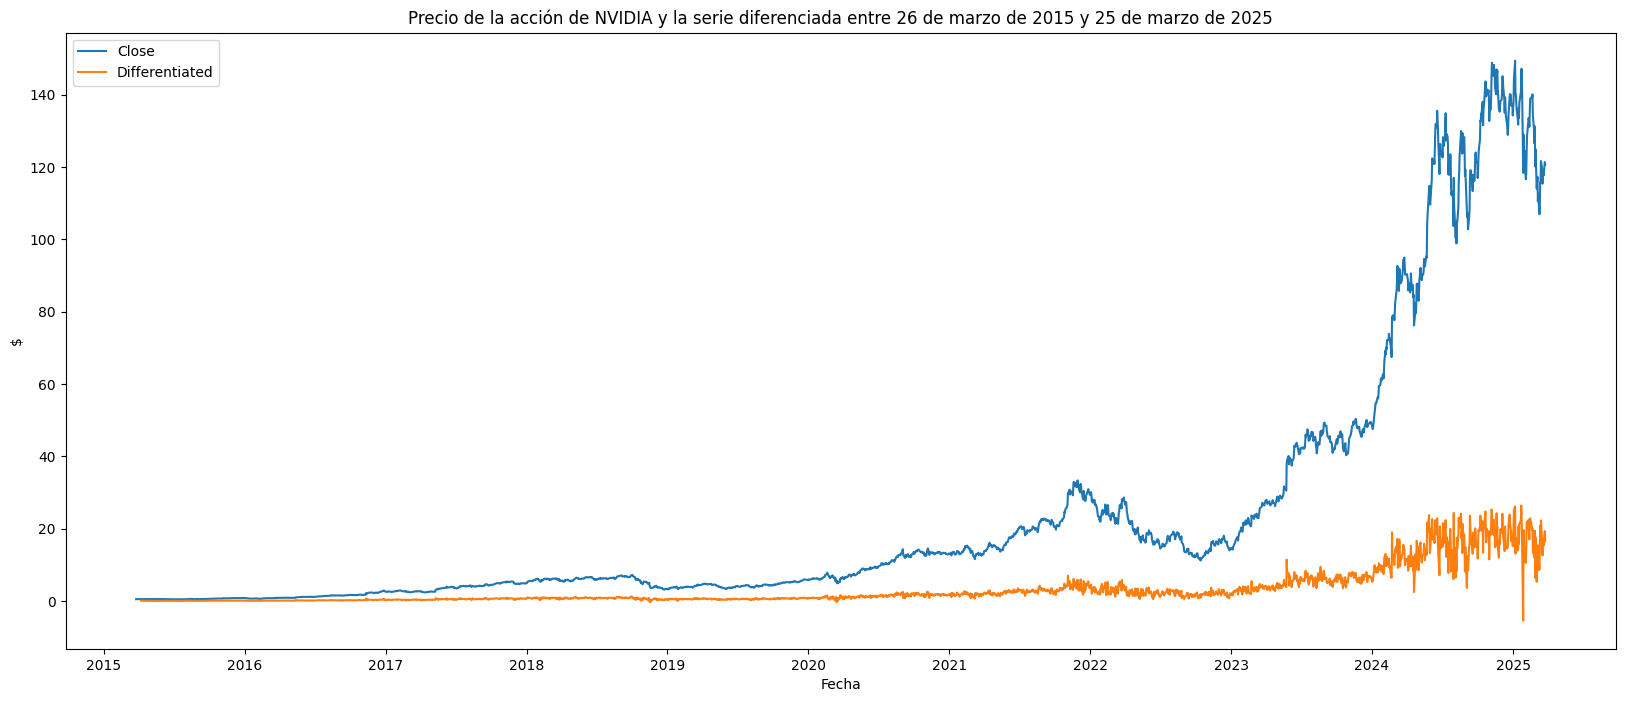

In [20]:
plt.figure(figsize=(20,8))
plt.plot(series, label='Close')
plt.plot(fd_ts, label="Differentiated")
plt.title('Precio de la acción de NVIDIA y la serie diferenciada entre 26 de marzo de 2015 y 25 de marzo de 2025')
plt.xlabel('Fecha')
plt.ylabel('$')
plt.legend()
plt.savefig('differenced.png');

In [21]:
# Verficiación de la estacionariedad de la serie diferenciada por fracciones

Augmented_Dickey_Fuller_Test_func(fd_ts, 'close')

Results of Dickey-Fuller Test for column: close
                        Metric        Value
0               Test Statistic    -4.991819
1                      p-value     0.000023
2                 No Lags Used     1.000000
3  Number of Observations Used  2505.000000
0          Critical Value (1%)    -3.432963
1          Critical Value (5%)    -2.862694
2         Critical Value (10%)    -2.567385
Conclusion:====>
Reject the null hypothesis
Data is stationary


# Calibrando un modelo de muestra

In [22]:
part = 5
X = fd_ts
y_train, y_test = X[:-part], X[-part:]
fcs_w = 10

In [23]:
y_train

,close
idx,
2015-04-08,0.080540
2015-04-09,0.089330
2015-04-10,0.086608
2015-04-13,0.075750
2015-04-14,0.072038
...,...
2025-03-12,20.866442
2025-03-13,16.849497
2025-03-14,22.312170


# Calibrando el modelo ARFIMA

In [24]:
print(f'ARFIMA Model')
model = auto_arima(y_train, 
                   start_p=1, 
                   start_q=1, 
                   max_p=15, 
                   max_q=15,
                   d=0, 
                   trace=True, 
                   error_action='ignore', 
                   suppress_warnings=True, 
                   stepwise=True)

print(f'Model summary')
model.summary()

ARFIMA Model
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=9119.174, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=15206.782, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=9893.447, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=13251.427, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=16056.540, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=9050.262, Time=1.24 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=9319.600, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=8971.756, Time=1.63 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=9275.449, Time=0.37 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=8966.567, Time=2.23 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=9209.381, Time=0.45 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=8968.516, Time=3.34 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=8970.234, Time=1.74 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8967.360, Time=1.76 sec
 ARIMA(5,0,0)(0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2502
Model:               SARIMAX(4, 0, 1)   Log Likelihood               -4476.706
Date:                Mon, 31 Mar 2025   AIC                           8965.411
Time:                        09:55:09   BIC                           9000.360
Sample:                             0   HQIC                          8978.099
                               - 2502                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2482      0.007    172.346      0.000       1.234       1.262
ar.L2         -0.0497      0.011     -4.568      0.000      -0.071      -0.028
ar.L3         -0.2555      0.012    -21.289      0.000      -0.279      -0.232
ar.L4          0.0568      0.008      7.128      0.000       0.041       0.072
ma.L1         -0.9291      0.004   -214.728      0.000      -0.938      -0.921
sigma2         2.0930      0.014    154.202      0.000       2.066       2.120
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):            228119.39
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):             916.49   Skew:                            -1.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
forecast,conf_int = model.predict(n_periods= part, exogenous = None,return_conf_int=True)

In [26]:
conf_int

array([[11.64763945, 17.31862192],
       [11.57615336, 17.52886143],
       [12.0149972 , 18.28738989],
       [12.03535028, 18.37617106],
       [12.12919879, 18.53661745]])

In [27]:
forecast

2502    14.483131
2503    14.552507
2504    15.151194
2505    15.205761
2506    15.332908
dtype: float64

In [28]:
y_test

,close
idx,
2025-03-19,16.895681
2025-03-20,17.002534
2025-03-21,15.379167
2025-03-24,19.351669
2025-03-25,16.467564


# Reconstruyendo los valores pronósticados por el modelo ARFIMA

In [29]:
# Precios pronósticados
start = y_train.index[-1]
original = df[['close']][-len(w_l)-part+1:-part]
reconstructed_values(forecast, w_l, original, start)

[115.10745005994146,
 114.65656907710171,
 114.89490425665166,
 115.00344891916295,
 115.1333814629064]

In [30]:
# Intervalo de confianza inferior en escala de precios
reconstructed_values(conf_int[:,0], w_l, original, start)

[112.27195882348494,
 110.00727521090698,
 108.6726718636512,
 107.43840157423607,
 106.35230348698369]

In [31]:
# Intervalo de confianza inferior en escala de precios
reconstructed_values(conf_int[:,1], w_l, original, start)

[117.94294129639798,
 119.30586294329643,
 121.11713664965212,
 122.56849626408983,
 123.91445943882911]

In [32]:
def forcast_ci_df(fdyh_lci,fdyh, fdyh_uci, w_l, original, start, end):
    columns = ['y_h_lower', 'y_hat', 'y_h_upper']
    reconstructed_l = reconstructed_values(fdyh_lci, w_l, original, start)
    reconstructed_y = reconstructed_values(fdyh, w_l, original, start)
    reconstructed_u = reconstructed_values(fdyh_uci, w_l, original, start)
    reconstructed_array = np.array([reconstructed_l, reconstructed_y, reconstructed_u])
    y_t = np.array(original.iloc[-1])[0]
    y_hat_matrix = np.array([y_t,y_t,y_t])
    y_hat_matrix = np.concatenate((y_hat_matrix.reshape(-1, 1), reconstructed_array),axis=1)
    dates_index = pd.bdate_range(start=start, end=end)
    return pd.DataFrame(y_hat_matrix.T, columns = columns, index=dates_index)

In [33]:
end='2025-03-25'
df_forecast = forcast_ci_df(conf_int[:,0],forecast, conf_int[:,1], w_l, original, start, end)
df_forecast

,y_h_lower,y_hat,y_h_upper
2025-03-18,115.430000,115.430000,115.430000
2025-03-19,112.271959,115.107450,117.942941
2025-03-20,110.007275,114.656569,119.305863
2025-03-21,108.672672,114.894904,121.117137
2025-03-24,107.438402,115.003449,122.568496
2025-03-25,106.352303,115.133381,123.914459


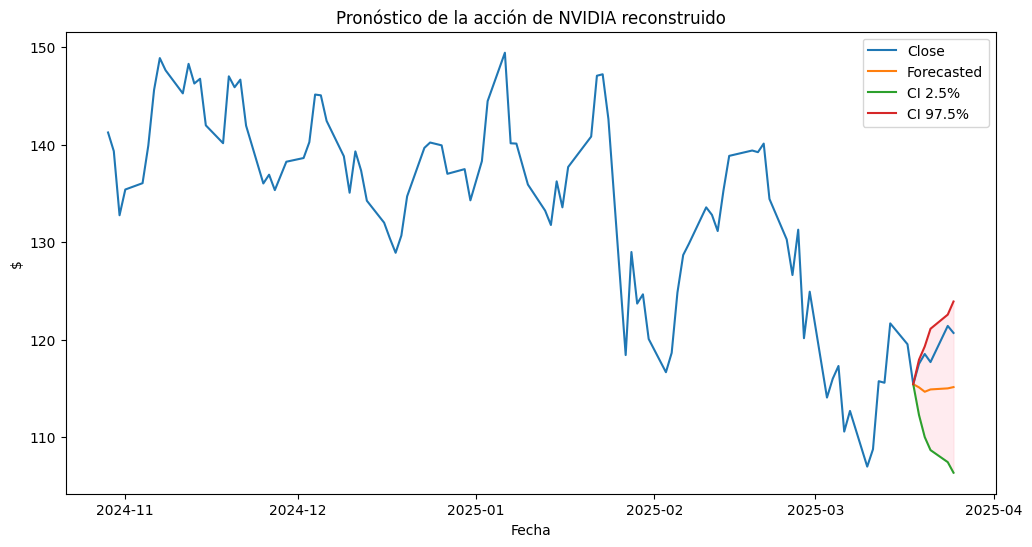

In [34]:
plt.figure(figsize=(12,6))
plt.title('Pronóstico de la acción de NVIDIA reconstruido')
plt.plot(df['close'][-100:], label='Close')
plt.plot(df_forecast['y_hat'] , label='Forecasted')
plt.plot(df_forecast['y_h_lower'], label='CI 2.5%')
plt.plot(df_forecast['y_h_upper'], label='CI 97.5%')
plt.fill_between(df_forecast.iloc[:].index,
                 df_forecast['y_h_upper'],
                 df_forecast['y_h_lower'],
                 color='pink', alpha=0.3);
plt.xlabel('Fecha')
plt.ylabel('$')
plt.legend()
plt.savefig('reconstruction.png');